In this Notebook we will discuss on problems that can we solved via LSTM networks. We will discuss on the following problems:
1. Classification problems
2. Word Generation Problem

In [1]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_pytorch_nlp"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_pytorch_nlp


In [3]:
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [4]:
import torch
from torchinfo import summary
import torchtext
import os
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import ngrams_iterator
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
import re
from torchview import draw_graph
from torcheval.metrics import MulticlassAccuracy, BinaryAccuracy
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from src.pytorch_helpers import *
from torch.optim import Adam

plt.rcParams["figure.figsize"] = (25, 20)

In [5]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)
import re
import string
from string import digits

In [6]:
from torchtext import data
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 16
epochs = 10
lr = 1e-3

Random seed set as 42
cuda


## Classification Task

In [8]:
spam_df = pd.read_csv("./data/sms_spam.csv", encoding="utf-8")

In [9]:
spam_df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


#### Data Cleanup andCustom Torch DataPrep

In [10]:
def basic_text_cleaning(data, col):

    data = data.copy()
    # lower and remove quotes
    data[col] = data[col].parallel_apply(lambda x: re.sub("'", "", x).lower())
    # remove special chars
    exclude = set(string.punctuation)  # set of all special chars
    # remove all the special chars
    data[col] = data[col].parallel_apply(
        lambda x: "".join(ch for ch in x if ch not in exclude)
    )
    # remove digits
    remove_digits = str.maketrans("", "", digits)
    data[col] = data[col].parallel_apply(lambda x: x.translate(remove_digits))

    # Remove extra spaces
    data[col] = data[col].parallel_apply(lambda x: x.strip())

    return data

In [11]:
np.mean(spam_df["text"].apply(lambda x: len(x)))

80.44492285611769

In [12]:
spam_df = basic_text_cleaning(spam_df, "text")

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [13]:
np.mean(spam_df["text"].apply(lambda x: len(x)))

73.76533907427341

In [14]:
spam_df["type"] = spam_df["type"].apply(lambda x: 1 if x == "spam" else 0)

In [15]:
# Train and validation set
train_df, valid_df = train_test_split(
    spam_df, test_size=0.2, random_state=42, stratify=spam_df["type"]
)

In [16]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [17]:
print(train_df.shape, valid_df.shape)

(4459, 2) (1115, 2)


Vocabulary creation

In [18]:
tokenizer = get_tokenizer("basic_english")
print(tokenizer(spam_df["text"].iloc[0]))

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']


In [19]:
class TorchVocabulary:
    """
    Class to create the vocabulary for the text data

    Args:
    freq_threshold: int: frequency threshold for the words
    max_size: int: maximum size of the vocabulary
    tokenizer: tokenizer: tokenizer to tokenize the text

    """

    def __init__(self, freq_threshold, max_size, tokenizer) -> None:
        self.freq_threshold = freq_threshold
        self.max_size = max_size

        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.itos)

    def tokenization(self, text):
        return self.tokenizer(text)

    def build_vocabulary(self, sentence_list):
        """Build the vocabulary from the sentence list"""
        # calculate the frequencies of each word first to remove the words with freq < freq_threshold
        overall_word_counts = Counter()  # init the freq dict
        idx = 4  # index from which we want our dict to start. We already used 4 indexes for pad, start, end, unk

        for sentence in sentence_list:
            sentence_word_counts = Counter(self.tokenization(sentence))
            # Update the overall word counts
            overall_word_counts.update(sentence_word_counts)

        # remove low freq words
        frequencies = {
            k: v for k, v in overall_word_counts.items() if v >= self.freq_threshold
        }

        # limit the vocab size to max_size
        frequencies = dict(
            sorted(frequencies.items(), key=lambda x: -x[1])[: self.max_size]
        )

        # update stoi and itos post index 4 for the new words
        for word in frequencies:
            self.stoi[word] = idx
            self.itos[idx] = word
            idx += 1

    def create_text_vectors(self, text):
        """Convert the text to vectors"""
        tokens = self.tokenization(text)
        vec = [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokens]
        return vec

In [20]:
# let's set the vocabulary for entire data together and use is as reference in CustomDataset
vocabulary = TorchVocabulary(freq_threshold=1, max_size=10000, tokenizer=tokenizer)
vocabulary.build_vocabulary(spam_df["text"].tolist())

In [21]:
print(len(vocabulary))

8691


In [22]:
# sentences = [
#     "Hello world! Hello everyone.",
#     "This is a test.",
#     "Hello again, world."
# ]
# vocabulary.build_vocabulary(sentences)
# vocabulary.create_text_vectors("I hello test world cool")

In [23]:
class TorchDataset:
    """
    Custom Dataset class for the spam classification task

    Args:
    vocabulary: TorchVocabulary object
    data: pandas dataframe
    source_col: source column name
    target_col: target column name

    Returns:
    source_text: source text
    target_text: target text
    """

    def __init__(self, vocabulary, data, source_col, target_col) -> None:
        self.data = data
        self.vocabulary = vocabulary
        self.source = self.data[source_col].tolist()
        self.target = self.data[target_col].tolist()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        source_text = self.source[idx]
        target_text = self.target[idx]

        # numericalize texts ['<SOS>','cat', 'in', 'a', 'bag','<EOS>'] -> [1,12,2,9,24,2]
        numerialized_source = [self.vocabulary.stoi["<SOS>"]]  # start token
        numerialized_source += self.vocabulary.create_text_vectors(
            source_text
        )  # middle tokens
        numerialized_source.append(self.vocabulary.stoi["<EOS>"])  # end token
        # target adjusments

        return torch.tensor(numerialized_source, dtype=torch.int32).to(
            device
        ), torch.tensor(target_text, dtype=torch.float32).to(device)

In [24]:
valid_df.head()

,type,text
0,0,no messageno responcewhat happend
1,0,at what time should i come tomorrow
2,0,come to my home for one last time i wont do anything trust me
3,1,get ur st ringtone free now reply to this msg with tone gr top tones to your phone every week just £ per wk opt out send stop
4,0,see you there


In [25]:
train_dataset = TorchDataset(vocabulary, train_df, "text", "type")
valid_dataset = TorchDataset(vocabulary, valid_df, "text", "type")

In [26]:
print(next(iter(train_dataset)))
print(next(iter(valid_dataset)))

(tensor([  1,  49,   5,  64,  21,   8, 136,   4,  83,  98,  98,   2],
       device='cuda:0', dtype=torch.int32), tensor(0., device='cuda:0'))
(tensor([   1,   40, 2619, 2620, 2077,    2], device='cuda:0',
       dtype=torch.int32), tensor(0., device='cuda:0'))


Collate Function - add functional padding by batch

In [27]:
class TorchCollate:
    """
    Custom collate function to pad the sequences in the batch.

    Args:
    pad_idx: int: padding index

    Returns:
    source: torch.tensor: padded source sequences
    target: torch.tensor: target sequences


    """

    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        source = [item[0] for item in batch]
        target = [item[1] for item in batch]

        # pad them using pad_sequence method from pytorch.
        source = pad_sequence(source, batch_first=True, padding_value=self.pad_idx)

        target = torch.stack(target)
        return source, target

In [28]:
def get_train_loader(dataset, batch_size, num_workers=0, shuffle=True):
    pad_idx = dataset.vocabulary.stoi["<PAD>"]
    # define loader
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        collate_fn=TorchCollate(pad_idx=pad_idx),
    )
    return loader

In [29]:
# dataloader - train and valid
train_dataloader = get_train_loader(train_dataset, batch_size=batch_size)
valid_dataloader = get_train_loader(valid_dataset, batch_size=batch_size)

In [30]:
for X, Y in train_dataloader:
    print(X.shape, Y.shape)
    break

torch.Size([16, 29]) torch.Size([16])


Ideal Reference to create data for any nlp model using Pytorch is 

https://towardsdatascience.com/custom-datasets-in-pytorch-part-2-text-machine-translation-71c41a3e994e

https://github.com/UtkarshGarg-UG/Deep-Learning-Projects/blob/main/NLP/Custom%20Dataset/loading%20custom%20dataset%20(text).ipynb

#### LSTM Model Building

In [31]:
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        num_layers,
        num_classes,
        dropout=0.2,
    ) -> None:
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def init_weights(self, X_batch):
        hidden, carry = torch.randn(
            self.num_layers, X_batch.size(0), self.hidden_dim
        ), torch.randn(self.num_layers, X_batch.size(0), self.hidden_dim)
        return hidden.to(device), carry.to(device)

    def forward(self, X_batch):
        x = self.embedding(X_batch)
        # print(x.shape)
        hidden, carry = self.init_weights(X_batch)
        out, (hidden, carry) = self.lstm(x, (hidden, carry))
        out = self.fc(out[:, -1, :])
        return out

In [32]:
stacked_lstm_model = LSTMClassifier(
    vocab_size=len(vocabulary),
    embedding_dim=100,
    hidden_dim=256,
    num_layers=2,
    num_classes=1,
)
stacked_lstm_model.to(device)

LSTMClassifier(
  (embedding): Embedding(8691, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [33]:
# driver setup
optimizer = optim.Adam(stacked_lstm_model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()
metric = BinaryAccuracy(device = device)

In [34]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        stacked_lstm_model,
        device,
        train_dataloader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        stacked_lstm_model,
        device,
        valid_dataloader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )

Epoch 0


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/279 [00:00<?, ?it/s]

Avg Train Loss: 0.3466621997322233 Avg Train Metric: 0.8735743733289848: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:06<00:00, 45.64it/s]


Epoch 1


Avg Train Loss: 0.3154232387955043 Avg Train Metric: 0.8758281757754665: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:03<00:00, 72.50it/s]


Epoch 2


Avg Train Loss: 0.37985180395798873 Avg Train Metric: 0.8673118786572556: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:03<00:00, 72.81it/s]


Epoch 3


Avg Train Loss: 0.315894266316754 Avg Train Metric: 0.8687456438191048: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:03<00:00, 71.75it/s]


Epoch 4


Avg Train Loss: 0.22295482939369576 Avg Train Metric: 0.8815586325515555: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:03<00:00, 71.40it/s]


Epoch 5


Avg Train Loss: 0.10627199248260548 Avg Train Metric: 0.9590742254769931: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:03<00:00, 71.20it/s]


Epoch 6


Avg Train Loss: 0.08080518100490813 Avg Train Metric: 0.9763007749366076: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:03<00:00, 72.41it/s]


Epoch 7


Avg Train Loss: 0.05135398029973964 Avg Train Metric: 0.988504484562891: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:03<00:00, 73.41it/s]


Epoch 8


Avg Train Loss: 0.040837607089443444 Avg Train Metric: 0.9916076920793048: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:03<00:00, 70.32it/s]


Epoch 9


Avg Train Loss: 0.04114050048113029 Avg Train Metric: 0.9929383100147315: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:04<00:00, 69.60it/s]


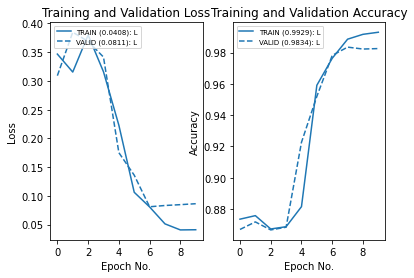

In [35]:
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels="LSTM",
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

References for Classification using LSTM
    
https://www.kaggle.com/code/mehmetlaudatekman/lstm-text-classification-pytorch

https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/

https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df

https://jovian.ml/aakanksha-ns/lstm-multiclass-text-classification

https://medium.com/@spandey8312/text-classification-using-custom-data-and-pytorch-d88ba1087045

https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-lstm-for-text-classification-tasks


### Application of Custom Embeddings for the LSTM model

Glove Embeddings - Passing the data preprocesed as embedding vectors

In [36]:
from torchtext.vocab import GloVe

In [37]:
# global_vectors = GloVe(name='6B', dim=300)
# vector = global_vectors.get_vecs_by_tokens(tokenizer("Hello, How are you?"), lower_case_backup=True)
# print(vector.shape)
# print(vector.dtype)
# len(global_vectors)


In [38]:
class TorchGloveVocabulary:
    """
    Class to create the vocabulary for the text data

    Args:
    tokenizer: tokenizer: tokenizer to tokenize the text

    """

    def __init__(self, tokenizer, max_words) -> None:

        self.glove = GloVe(name="6B", dim=300)
        self.max_words = max_words
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.glove)

    def tokenization(self, text):
        return self.tokenizer(text)

    def create_text_vectors(self, text):
        """Convert the text to vectors"""
        tokens = self.tokenization(text)
        tokens = (
            tokens + [""] * (self.max_words - len(tokens))
            if len(tokens) < self.max_words
            else tokens[: self.max_words]
        )
        vec = self.glove.get_vecs_by_tokens(tokens=tokens, lower_case_backup=True)

        return vec

In [39]:
class TorchGloveDataset:
    """
    Custom Dataset class for the spam classification task

    Args:
    vocabulary: TorchVocabulary object
    data: pandas dataframe
    source_col: source column name
    target_col: target column name

    Returns:
    source_text: source text
    target_text: target text
    """

    def __init__(self, vocabulary, data, source_col, target_col) -> None:
        self.data = data
        self.vocabulary = vocabulary
        self.source = self.data[source_col].tolist()
        self.target = self.data[target_col].tolist()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        source_text = self.source[idx]
        target_text = self.target[idx]

        numerialized_source = self.vocabulary.create_text_vectors(source_text)

        return torch.tensor(
            numerialized_source.clone().detach(), dtype=torch.float32
        ).to(device), torch.tensor(target_text, dtype=torch.float32).to(device)

In [40]:
vocabulary = TorchGloveVocabulary(tokenizer, 100)

In [41]:
train_dataset = TorchGloveDataset(vocabulary, train_df, "text", "type")
valid_dataset = TorchGloveDataset(vocabulary, valid_df, "text", "type")

In [42]:
x, y = next(iter(train_dataset))
print(x.shape, y.shape)

torch.Size([100, 300]) torch.Size([])


<ipython-input-39-a9b57342a2e8>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


In [43]:
class TorchGloveCollate:
    """
    Custom collate function to pad the sequences in the batch.

    Args:
    pad_idx: int: padding index

    Returns:
    source: torch.tensor: padded source sequences
    target: torch.tensor: target sequences


    """

    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        source = [item[0] for item in batch]
        target = [item[1] for item in batch]

        # pad them using pad_sequence method from pytorch.
        source = pad_sequence(source, batch_first=True, padding_value=self.pad_idx)
        target = torch.stack(target)
        return source, target


In [44]:
def get_train_loader(dataset, batch_size, num_workers=0, shuffle=True):
    pad_idx = 0
    # define loader
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        collate_fn=TorchGloveCollate(pad_idx=pad_idx),
    )
    return loader

In [45]:
# dataloader - train and valid
train_dataloader = get_train_loader(train_dataset, batch_size=batch_size)
valid_dataloader = get_train_loader(valid_dataset, batch_size=batch_size)

In [46]:
for X, Y in train_dataloader:
    print(X.shape, Y.shape)
    break

torch.Size([16, 100, 300]) torch.Size([16])


<ipython-input-39-a9b57342a2e8>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


In [47]:
class LSTMGloveClassifier(nn.Module):
    def __init__(
        self,
        embedding_dim,
        hidden_dim,
        num_layers,
        num_classes,
        dropout=0.2,
    ) -> None:
        super(LSTMGloveClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # print(self.embedding_op)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def init_weights(self, X_batch):
        hidden, carry = torch.randn(
            self.num_layers, X_batch.size(0), self.hidden_dim
        ), torch.randn(self.num_layers, X_batch.size(0), self.hidden_dim)
        return hidden.to(device), carry.to(device)

    def forward(self, X_batch):
        # print(X_batch.shape)
        hidden, carry = self.init_weights(X_batch)
        out, (hidden, carry) = self.lstm(X_batch, (hidden, carry))
        out = self.fc(out[:, -1, :])
        return out

In [48]:
glove_lstm_model = LSTMGloveClassifier(
    embedding_dim=300, hidden_dim=256, num_layers=2, num_classes=1
)
glove_lstm_model.to(device)

LSTMGloveClassifier(
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [49]:
# driver setup
optimizer = optim.Adam(glove_lstm_model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()
metric = BinaryAccuracy(device = device)

In [50]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        glove_lstm_model,
        device,
        train_dataloader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        glove_lstm_model,
        device,
        valid_dataloader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )

Epoch 0


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/279 [00:00<?, ?it/s]<

Avg Train Loss: 0.4048355455947606 Avg Train Metric: 0.8709983601365038: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:08<00:00, 32.19it/s]


Epoch 1


Avg Train Loss: 0.396799938199127 Avg Train Metric: 0.8699150326858712: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:08<00:00, 31.35it/s]


Epoch 2


Avg Train Loss: 0.3963232655679026 Avg Train Metric: 0.8690440210390262: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:08<00:00, 31.85it/s]


Epoch 3


Avg Train Loss: 0.39479034912094846 Avg Train Metric: 0.8642906172728453: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:08<00:00, 31.93it/s]


Epoch 4


Avg Train Loss: 0.39549887385953714 Avg Train Metric: 0.8617947225502315: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:08<00:00, 31.95it/s]


Epoch 5


Avg Train Loss: 0.3957538030320598 Avg Train Metric: 0.8661448312489363: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:08<00:00, 31.52it/s]


Epoch 6


Avg Train Loss: 0.3952809700935972 Avg Train Metric: 0.8654068225600814: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:08<00:00, 31.23it/s]


Epoch 7


Avg Train Loss: 0.3963045842651825 Avg Train Metric: 0.8661060123887968: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:08<00:00, 32.31it/s]


Epoch 8


Avg Train Loss: 0.3958341327619382 Avg Train Metric: 0.8754304538490951: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:08<00:00, 31.61it/s]


Epoch 9


Avg Train Loss: 0.39390395042289544 Avg Train Metric: 0.8528744420270339: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:08<00:00, 31.65it/s]


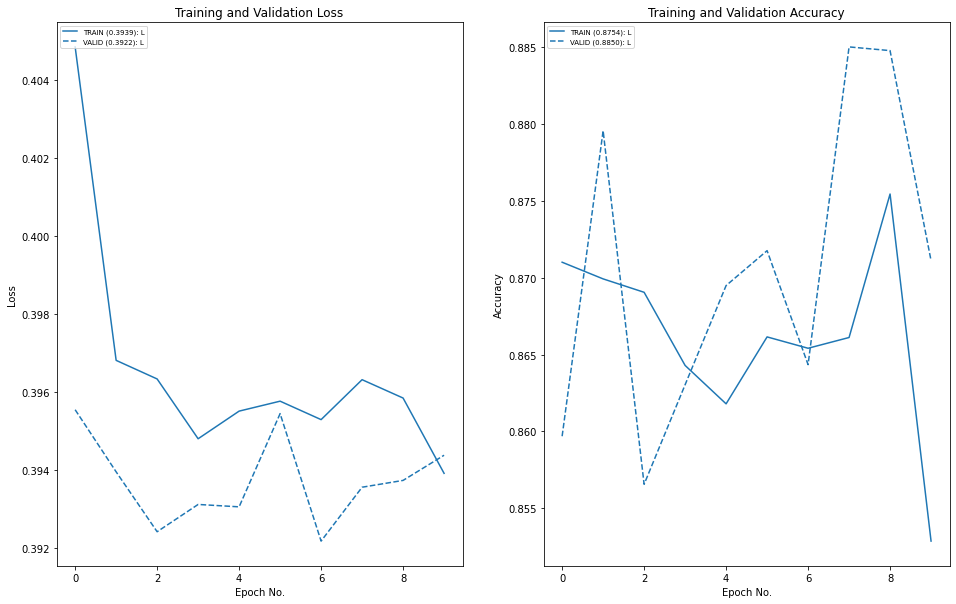

In [51]:
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels="LSTM_GLOVE",
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

References:

https://debuggercafe.com/pretrained-glove-embeddings/

https://coderzcolumn.com/tutorials/artificial-intelligence/how-to-use-glove-embeddings-with-pytorch

https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

https://stackoverflow.com/questions/58630101/using-torch-nn-embedding-for-glove-should-we-fine-tune-the-embeddings-or-just-u

https://stackoverflow.com/questions/49710537/pytorch-gensim-how-do-i-load-pre-trained-word-embeddings/49802495#49802495

Next:: How to use the weights of GloVe in the LSTM model as the embedding layer weights?

https://tanmay17061.medium.com/load-pre-trained-glove-embeddings-in-torch-nn-embedding-layer-in-under-2-minutes-f5af8f57416a